## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Valid - use only above a cutoff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [109]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from PIL import Image as pil_image
import matplotlib as mpl

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid_cf_verified'

In [7]:
NB_NUM='03_15'

In [8]:
border='reflect'

In [9]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 57d55570, DATE: 20191110


In [10]:
#DATE = '20191109'
#UID = '123cca5f'

In [11]:
SUB_NUM='18'

In [12]:
img_size=256

In [13]:
train_images=data_dir/f'train/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

In [14]:
test_names = get_image_files(test_images)

In [15]:
assert len(test_names)==7325

In [16]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [17]:
df_valid=df_all.loc[df_all['verified'] == True]

In [18]:
df_invalid=df_all.loc[df_all['verified'] == False]

In [19]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [20]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [21]:
assert len(df_test)==7325

In [22]:
df_valid.loc[df_valid['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [23]:
len(df_valid)

14870

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [24]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [25]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [26]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [27]:
#to check what params object has
#dir(data)

In [28]:
data.label_list

LabelLists;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256

In [29]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

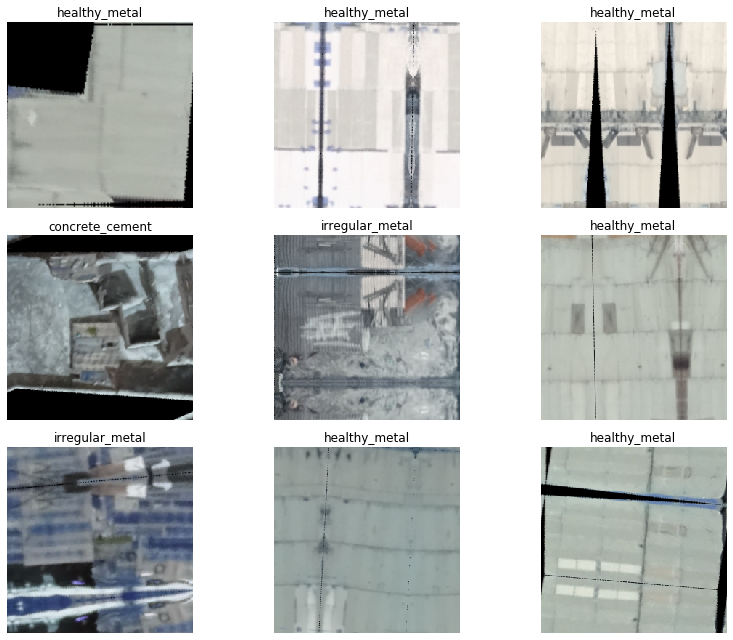

In [30]:
data.show_batch(rows=3, figsize=(12,9))

### Model 

Load a pre-trained model using only valid data, then predict on non verified images and keep those that match

In [31]:
arch = models.resnet50
arch_name = 'rn50'

In [32]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [33]:
P_DATE = '20191109'
P_UID = '123cca5f'
P_NB_NUM='03_11'
P_MODEL_NAME='cv_reflect_101_valid'
P_arch_name = 'rn50'

In [34]:
learn.load(f'stage-2-{P_arch_name}-{P_NB_NUM}-{P_MODEL_NAME}-{P_DATE}-{P_UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

### inference

#### pred as verified == False

In [342]:
test_dataset=ImageList.from_df(df=df_invalid, path=train_images, cols='id', folder='', suffix='.tif')


In [343]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
#test_dataset=ImageList.from_folder(test_images)

In [344]:
len(test_dataset)

7683

In [345]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [346]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [347]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [348]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [349]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [350]:
len(learn.dl(DatasetType.Test))

121

Get number of items in the Valid dataset (in DeviceDataLoader)

In [351]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [352]:
labels = np.argmax(preds, 1)

In [353]:
len(preds)

7683

In [354]:
preds[0].tolist()

[0.008805908262729645,
 0.9131764769554138,
 0.002267018426209688,
 0.007207256741821766,
 0.06854331493377686]

In [355]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [356]:
len(labels)

7683

In [357]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [358]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [359]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [360]:
test_predictions[0]

'healthy_metal'

In [361]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [362]:
 learn.data.test_ds.x.items

array(['data/train/rotated/clipped/reflect/256//7a24bd7e.tif', 'data/train/rotated/clipped/reflect/256//7a2cf00c.tif',
       'data/train/rotated/clipped/reflect/256//7a3975e8.tif', 'data/train/rotated/clipped/reflect/256//7a1d215e.tif',
       ..., 'data/train/rotated/clipped/reflect/256//7a2f73ea.tif',
       'data/train/rotated/clipped/reflect/256//7a34ffa4.tif', 'data/train/rotated/clipped/reflect/256//7a41560a.tif',
       'data/train/rotated/clipped/reflect/256//7a283ad0.tif'], dtype='<U52')

In [363]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [364]:
preds_list[0]

[0.008805908262729645,
 0.9131764769554138,
 0.002267018426209688,
 0.007207256741821766,
 0.06854331493377686]

In [365]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [366]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [367]:
df.head()

,id,pred
0,7a24bd7e,"[0.008805908262729645, 0.9131764769554138, 0.0..."
1,7a2cf00c,"[0.0010450048139318824, 0.994259238243103, 0.0..."
2,7a3975e8,"[0.001082373084500432, 0.9764257073402405, 0.0..."
3,7a1d215e,"[0.0007028037216514349, 0.9852086305618286, 0...."
4,7a42475e,"[0.014385167509317398, 0.9731370806694031, 0.0..."


In [368]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [369]:
pred_df.insert(loc=0, column='id', value=ids)

In [370]:
pred_df.columns = cols

In [371]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a24bd7e,0.008806,0.913176,0.002267,0.007207,0.068543
1,7a2cf00c,0.001045,0.994259,0.000526,0.003511,0.000659
2,7a3975e8,0.001082,0.976426,0.000773,0.020468,0.001251
3,7a1d215e,0.000703,0.985209,0.000670,0.002442,0.010977
4,7a42475e,0.014385,0.973137,0.001237,0.008855,0.002385


In [372]:
temp_df=pred_df.drop(columns=['id'])

In [373]:
classes=temp_df.idxmax(axis=1)

In [374]:
classes

0       healthy_metal
1       healthy_metal
2       healthy_metal
3       healthy_metal
4       healthy_metal
            ...      
7678    healthy_metal
7679    healthy_metal
7680    healthy_metal
7681    healthy_metal
7682    healthy_metal
Length: 7683, dtype: object

In [375]:
pred_df['pred']=classes

In [376]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,pred
0,7a24bd7e,0.008806,0.913176,0.002267,0.007207,0.068543,healthy_metal
1,7a2cf00c,0.001045,0.994259,0.000526,0.003511,0.000659,healthy_metal
2,7a3975e8,0.001082,0.976426,0.000773,0.020468,0.001251,healthy_metal
3,7a1d215e,0.000703,0.985209,0.000670,0.002442,0.010977,healthy_metal
4,7a42475e,0.014385,0.973137,0.001237,0.008855,0.002385,healthy_metal


In [377]:
df_invalid.head()

,id,roof_material,verified,country,region
13866,7a24bd7e,healthy_metal,False,st_lucia,castries
13867,7a2cf00c,healthy_metal,False,st_lucia,castries
13868,7a3975e8,healthy_metal,False,st_lucia,castries
13869,7a1d215e,healthy_metal,False,st_lucia,castries
13870,7a42475e,healthy_metal,False,st_lucia,castries


In [378]:
df_max = pred_df.max(axis=1)

In [379]:
df_max.head()

0    0.913176
1    0.994259
2    0.976426
3    0.985209
4    0.973137
dtype: float64

In [380]:
req_df=pred_df.drop(columns=['id','pred'])

In [381]:
df_class=req_df.idxmax(axis=1)

In [382]:
pred_df['confidence']=df_max

In [383]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,pred,confidence
0,7a24bd7e,0.008806,0.913176,0.002267,0.007207,0.068543,healthy_metal,0.913176
1,7a2cf00c,0.001045,0.994259,0.000526,0.003511,0.000659,healthy_metal,0.994259
2,7a3975e8,0.001082,0.976426,0.000773,0.020468,0.001251,healthy_metal,0.976426
3,7a1d215e,0.000703,0.985209,0.000670,0.002442,0.010977,healthy_metal,0.985209
4,7a42475e,0.014385,0.973137,0.001237,0.008855,0.002385,healthy_metal,0.973137


In [384]:
df_healthy_metal=pred_df.loc[pred_df['pred'] == 'healthy_metal']

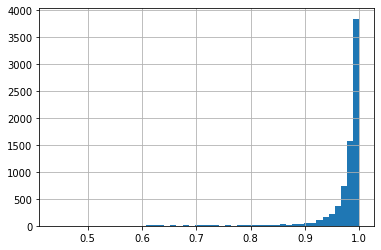

In [385]:
hist = df_healthy_metal.confidence.hist(bins=50)

In [386]:
healthy_metal_c=df_healthy_metal.loc[(df_healthy_metal['confidence'] >= 0.9)]

Use cutoff 0.9

In [387]:
df_concrete_cement=pred_df.loc[pred_df['pred'] == 'concrete_cement']

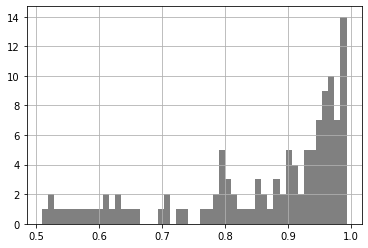

In [388]:
hist = df_concrete_cement.confidence.hist(bins=50, color='gray')

Use cutoff 0.85

In [389]:
concrete_cement_c=df_concrete_cement.loc[(df_concrete_cement['confidence'] >= 0.85)]

In [390]:
df_incomplete=pred_df.loc[pred_df['pred'] == 'incomplete']

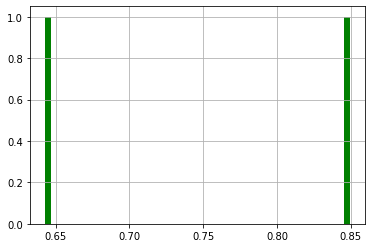

In [391]:
hist = df_incomplete.confidence.hist(bins=50, color='green')

use cutoff 0.8

In [392]:
incomplete_c=df_incomplete.loc[(df_incomplete['confidence'] >= 0.8)]

In [393]:
df_irregular_metal=pred_df.loc[pred_df['pred'] == 'irregular_metal']

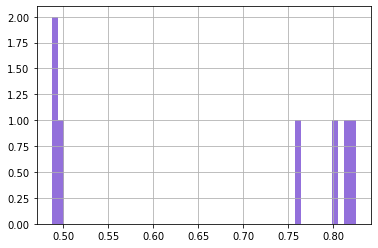

In [394]:
hist = df_irregular_metal.confidence.hist(bins=50, color='mediumpurple')

use cutoff 0.75

In [395]:
irregular_metal_c=df_irregular_metal.loc[(df_irregular_metal['confidence'] >= 0.75)]

In [396]:
df_other=pred_df.loc[pred_df['pred'] == 'other']

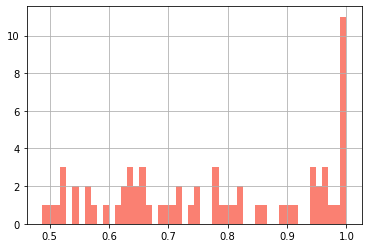

In [397]:
hist = df_other.confidence.hist(bins=50, color='salmon')

use cutoff 0.75

In [398]:
other_c=df_other.loc[(df_other['confidence'] >= 0.75)]

In [399]:
frames=[healthy_metal_c,concrete_cement_c,incomplete_c,irregular_metal_c,other_c]
df_cutoffs = pd.concat(frames)

In [400]:
len(df_cutoffs)

7250

In [401]:
df_cutoffs.to_csv(data_dir/f'pred_invalid_cutoffs-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### pred on test

In [402]:
test_dataset=ImageList.from_df(df=df_test, path=test_images, cols='id', folder='', suffix='.tif')


In [403]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
#test_dataset=ImageList.from_folder(test_images)

In [404]:
len(test_dataset)

7325

In [405]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [406]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [407]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [408]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [409]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [410]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [411]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [412]:
labels = np.argmax(preds, 1)

In [413]:
len(preds)

7325

In [414]:
preds[0].tolist()

[0.0009637018083594739,
 0.9918993711471558,
 0.0012495748233050108,
 0.0038719880394637585,
 0.002015387639403343]

In [415]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [416]:
len(labels)

7325

In [417]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [418]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [419]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [420]:
test_predictions[0]

'healthy_metal'

In [421]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [422]:
 learn.data.test_ds.x.items

array(['data/test/rotated/clipped/reflect/256//7a4d630a.tif', 'data/test/rotated/clipped/reflect/256//7a4bbbd6.tif',
       'data/test/rotated/clipped/reflect/256//7a4ac744.tif', 'data/test/rotated/clipped/reflect/256//7a4881fa.tif',
       ..., 'data/test/rotated/clipped/reflect/256//7a4fc578.tif',
       'data/test/rotated/clipped/reflect/256//7a4ac7b2.tif', 'data/test/rotated/clipped/reflect/256//7a47e25e.tif',
       'data/test/rotated/clipped/reflect/256//7a4e3f78.tif'], dtype='<U51')

In [423]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [424]:
preds_list[0]

[0.0009637018083594739,
 0.9918993711471558,
 0.0012495748233050108,
 0.0038719880394637585,
 0.002015387639403343]

In [425]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [426]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [427]:
df.head()

,id,pred
0,7a4d630a,"[0.0009637018083594739, 0.9918993711471558, 0...."
1,7a4bbbd6,"[0.0021748680155724287, 0.9916272163391113, 0...."
2,7a4ac744,"[0.008023924194276333, 0.4175572097301483, 0.0..."
3,7a4881fa,"[0.0016605549026280642, 0.01890132576227188, 0..."
4,7a4aa4a8,"[0.004692841321229935, 0.8536683320999146, 0.0..."


In [428]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [429]:
pred_df.insert(loc=0, column='id', value=ids)

In [430]:
pred_df.columns = cols

In [431]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.000964,0.991899,0.001250,0.003872,0.002015
1,7a4bbbd6,0.002175,0.991627,0.000803,0.004684,0.000711
2,7a4ac744,0.008024,0.417557,0.010922,0.561353,0.002144
3,7a4881fa,0.001661,0.018901,0.010896,0.968236,0.000307
4,7a4aa4a8,0.004693,0.853668,0.002853,0.135639,0.003147


In [432]:
temp_df=pred_df.drop(columns=['id'])

In [433]:
classes=temp_df.idxmax(axis=1)

In [434]:
classes

0         healthy_metal
1         healthy_metal
2       irregular_metal
3       irregular_metal
4         healthy_metal
             ...       
7320      healthy_metal
7321      healthy_metal
7322      healthy_metal
7323      healthy_metal
7324      healthy_metal
Length: 7325, dtype: object

In [435]:
pred_df['pred']=classes

In [436]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,pred
0,7a4d630a,0.000964,0.991899,0.001250,0.003872,0.002015,healthy_metal
1,7a4bbbd6,0.002175,0.991627,0.000803,0.004684,0.000711,healthy_metal
2,7a4ac744,0.008024,0.417557,0.010922,0.561353,0.002144,irregular_metal
3,7a4881fa,0.001661,0.018901,0.010896,0.968236,0.000307,irregular_metal
4,7a4aa4a8,0.004693,0.853668,0.002853,0.135639,0.003147,healthy_metal


In [437]:
df_max = pred_df.max(axis=1)

In [438]:
df_max.head()

0    0.991899
1    0.991627
2    0.561353
3    0.968236
4    0.853668
dtype: float64

In [439]:
req_df=pred_df.drop(columns=['id','pred'])

In [440]:
df_class=req_df.idxmax(axis=1)

In [441]:
pred_df['confidence']=df_max

In [442]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,pred,confidence
0,7a4d630a,0.000964,0.991899,0.001250,0.003872,0.002015,healthy_metal,0.991899
1,7a4bbbd6,0.002175,0.991627,0.000803,0.004684,0.000711,healthy_metal,0.991627
2,7a4ac744,0.008024,0.417557,0.010922,0.561353,0.002144,irregular_metal,0.561353
3,7a4881fa,0.001661,0.018901,0.010896,0.968236,0.000307,irregular_metal,0.968236
4,7a4aa4a8,0.004693,0.853668,0.002853,0.135639,0.003147,healthy_metal,0.853668


In [443]:
df_healthy_metal=pred_df.loc[pred_df['pred'] == 'healthy_metal']

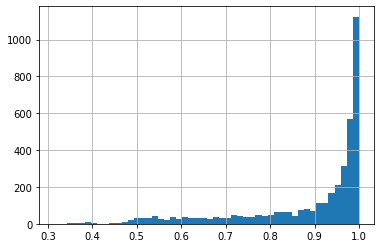

In [444]:
hist = df_healthy_metal.confidence.hist(bins=50)

In [445]:
healthy_metal_c=df_healthy_metal.loc[(df_healthy_metal['confidence'] >= 0.9)]

Use cutoff 0.9

In [446]:
df_concrete_cement=pred_df.loc[pred_df['pred'] == 'concrete_cement']

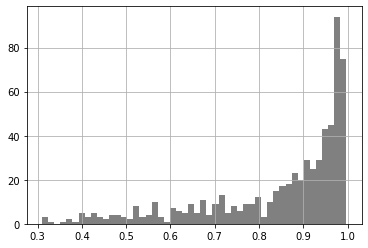

In [447]:
hist = df_concrete_cement.confidence.hist(bins=50, color='gray')

Use cutoff 0.85

In [448]:
concrete_cement_c=df_concrete_cement.loc[(df_concrete_cement['confidence'] >= 0.85)]

In [449]:
df_incomplete=pred_df.loc[pred_df['pred'] == 'incomplete']

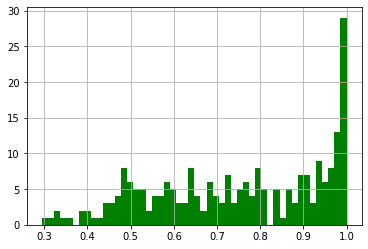

In [450]:
hist = df_incomplete.confidence.hist(bins=50, color='green')

use cutoff 0.8

In [451]:
incomplete_c=df_incomplete.loc[(df_incomplete['confidence'] >= 0.85)]

In [452]:
df_irregular_metal=pred_df.loc[pred_df['pred'] == 'irregular_metal']

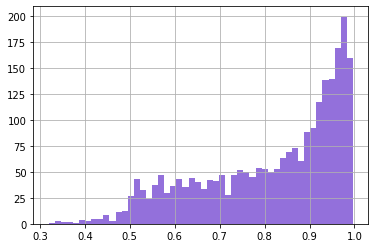

In [453]:
hist = df_irregular_metal.confidence.hist(bins=50, color='mediumpurple')

use cutoff 0.75

In [454]:
irregular_metal_c=df_irregular_metal.loc[(df_irregular_metal['confidence'] >= 0.85)]

In [455]:
df_other=pred_df.loc[pred_df['pred'] == 'other']

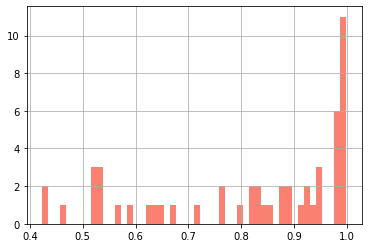

In [456]:
hist = df_other.confidence.hist(bins=50, color='salmon')

use cutoff 0.75

In [457]:
other_c=df_other.loc[(df_other['confidence'] >= 0.8)]

In [458]:
frames=[healthy_metal_c,concrete_cement_c,incomplete_c,irregular_metal_c,other_c]
df_cutoffs = pd.concat(frames)

In [459]:
len(df_cutoffs)

4462

In [460]:
df_cutoffs.to_csv(data_dir/f'test_cutoffs-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [461]:
def mpl_show(new_im, label, title=''):
    plt.imshow(new_im, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    text = label+' '+title
    plt.title(text)
    plt.show()
    plt.close()

In [94]:
im = pil_image.open(train_images/'7a295212.tif')

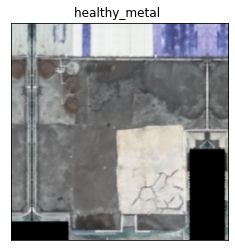

In [96]:
mpl_show(im, 'healthy_metal')

In [98]:
im = pil_image.open(train_images/'7a26dfa0.tif')

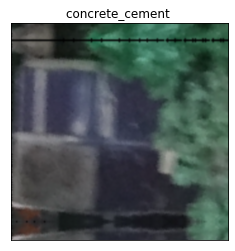

In [99]:
mpl_show(im, 'concrete_cement')